In [ ]:
!git clone https://github.com/misbah4064/human-pose-estimation-opencv.git
%cd human-pose-estimation-opencv/

Cloning into 'human-pose-estimation-opencv'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 20 (delta 5), reused 17 (delta 5), pack-reused 0
Unpacking objects: 100% (20/20), 10.09 MiB | 12.62 MiB/s, done.
/content/human-pose-estimation-opencv


Angle: 101.53 degrees
Processing time: 0.218 seconds


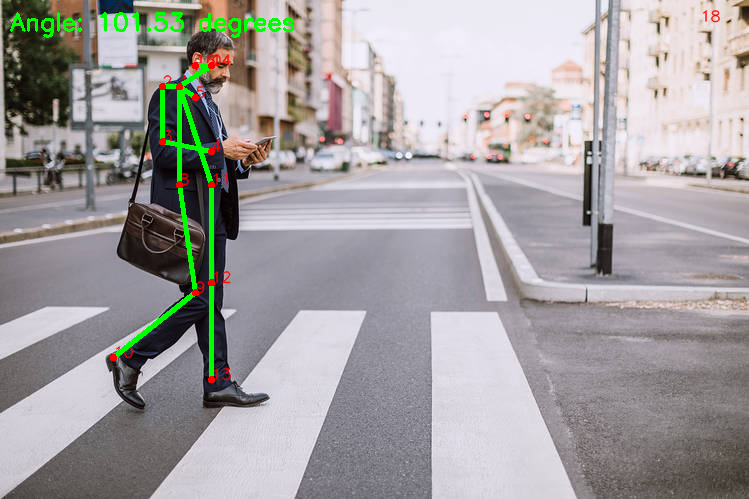

In [ ]:
#라이브러리 및 모듈 가져오기
import cv2 as cv
import numpy as np
from google.colab.patches import cv2_imshow

#BODY_PARTS : joint / 사람의 신체 부위를 나타내는 레이블고 해당 인덱스
#POSE_PAIRS : bone (joint연결) / 연결할 신체 부위 쌍을 정의
BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
               ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

#모델 로드 및 초기화
width = 368
height = 368
inWidth = width
inHeight = height

net = cv.dnn.readNetFromTensorflow("graph_opt.pb")
thr = 0.1

#calculate_angle 함수 정의
#세 개의 포인트를 입력으로 받아 각도를 계산하는 함수

def calculate_angle(point1, point2, point3):
    # 세 점 사이의 각도를 계산
    vector1 = np.array(point1) - np.array(point2)
    vector2 = np.array(point3) - np.array(point2)

    dot_product = np.dot(vector1, vector2)
    magnitude_product = np.linalg.norm(vector1) * np.linalg.norm(vector2)
    angle_radians = np.arccos(dot_product / magnitude_product)
    angle_degrees = np.degrees(angle_radians)

    return angle_degrees

#poseDetector 함수 정의
#입력된 프레임에서 사람의 신체 부위를 탐지하고, 포즈를 시각화하는 함수
#출력을 기반으로 신체 부위 포인트를 추출하고, 해당 포인트를 시각적으로 나타냄
#특정 포인트를 사용하여 각도를 계산하고, 프레임에 각도를 표시

def poseDetector(frame):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]

    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]

    assert(len(BODY_PARTS) == out.shape[1])

    points = []
    for i in range(len(BODY_PARTS)):
        heatMap = out[0, i, :, :]

        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        points.append((int(x), int(y)) if conf > thr else None)

        if conf > thr:
            cv.putText(frame, str(i), (int(x), int(y)), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv.LINE_AA)

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    if points[2] and points[3] and points[4]:
        angle = calculate_angle(points[2], points[3], points[4])
        cv.putText(frame, "Angle: {:.2f} degrees".format(angle), (10, 30), cv.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
        print("Angle: {:.2f} degrees".format(angle))
    return frame

#이미지 파일 로드 및 처리
image_path = "/content/Untitled (6).png"
frame = cv.imread(image_path)

# 시간측정
start_time = cv.getTickCount()

output_frame = poseDetector(frame)

end_time = cv.getTickCount()
elapsed_time = (end_time - start_time) / cv.getTickFrequency()
print("Processing time: {:.3f} seconds".format(elapsed_time))


# 결과 이미지 표시
cv2_imshow(output_frame)
cv.waitKey(0)
cv.destroyAllWindows()